In [1]:
from pathlib import Path


import evaluation_utils as eval_u
import deeplab_utils as dl_u
import OCR_utils as OCR_u
import image_utils as image_u
import mapping_utils as mapping_u

import difflib
import os

import shapely
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.geometry import mapping, shape
import shapely.wkt

import matplotlib.pyplot as plt

from mxnet import image

import json
import string
import numpy as np
import pandas as pd
import pickle
import random


import time

Using TensorFlow backend.
[nltk_data] Downloading package maxent_ne_chunker to C:\Users\Agathe
[nltk_data]     Balayn\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Agathe
[nltk_data]     Balayn\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Get the predictions: hand-made rules

In [ ]:
#input_image_file = '2017_11534654.jpg'

# Hyper-parameters of our method
mapping_type = "simple_rule"
methods_to_account = ["semantic_segmentation", "OCR"]
type_semantic_seg_rule = "simple_list"
type_OCR_rule = "simple_rule"
type_scene_rule = "todo"
save_groundtruth = True
prepare_tools = True
ground_truth_file = '../val2017.json'

# Test with 10 test images.
path_image_folder = '../dataset_images/'
pathlist = Path(path_image_folder).glob('**/*.*')


# Prepare recurring tools.
if prepare_tools:
    dict_preparation = mapping_u.prepare_needed_elements(methods_to_account)
    needed_input = mapping_u.prepare_OCR_name_matching()

nb_image = 0
# Process each image.

#pathlist = ['2017_11534654.jpg']
for input_image_file in pathlist:
    start = time.time()
    nb_image += 1
    print("Processing image nb", str(nb_image), input_image_file)
    if nb_image >= 65:
        # Process the images to get potential private elements
        inputs_to_mapping_semantic_segmentation, inputs_to_mapping_OCR, inputs_to_mapping_scene = \
        mapping_u.get_input_to_mapping(input_image_file, methods_to_account, dict_preparation)
        print(inputs_to_mapping_OCR)

        # Filter the elements with the mapping
        if len(inputs_to_mapping_semantic_segmentation) == 0:
            inputs_to_mapping_semantic_segmentation = [[]]
        #print(inputs_to_mapping_OCR)
        if len(inputs_to_mapping_OCR) == 0:
            inputs_to_mapping_OCR = [[]]
        #print(inputs_to_mapping_OCR)
        polys_to_obfuscate = mapping_u.ruleBasedMapping(type_semantic_seg_rule, type_OCR_rule, type_scene_rule, inputs_to_mapping_semantic_segmentation[0], inputs_to_mapping_OCR[0], inputs_to_mapping_scene, needed_input)

        # Post-process the final polygons
        if len(polys_to_obfuscate) > 1:
            polys_to_obfuscate_final = image_u.post_process_polygons(polys_to_obfuscate)
        else:
            polys_to_obfuscate_final = polys_to_obfuscate

        # Save the polygons
        image_u.save_polygons("simple_mapping_poly_09.json", polys_to_obfuscate_final, Path(input_image_file).stem)

        # Save the images
        # Prediction polygons
        save_file = Path("simple_mapping_images_09/") / (Path(input_image_file).stem + ".png")
        #printPolygons(input_image_file, polys_to_obfuscate, save_file)
        image_u.printPolygons(input_image_file, polys_to_obfuscate_final, save_file)

        # Ground truth polygons
        if save_groundtruth:
            list_GT_polygons = image_u.prepare_GT_polygon(input_image_file, ground_truth_file)
            save_file = Path("ground_truth_images/") / (Path(input_image_file).stem + ".png")
            #printPolygons(input_image_file, polys_to_obfuscate, save_file)
            image_u.printPolygons(input_image_file, list_GT_polygons, save_file)

    end = time.time()
    print("Time to process image: ", end - start)

# Evaluation

In [3]:
# Read the ground truth file.
with open(Path('../val2017.json'), 'r') as f:
    ground_truth = json.load(f)
ground_truth = ground_truth['annotations']
# Read the prediction file.
with open(Path("simple_mapping_poly_09.json"), 'r') as f:
    list_predictions = json.load(f)
list_predictions = list_predictions["list_image_poly"]


In [4]:
prediction_list = list_predictions
ground_truth_list = ground_truth

In [5]:
rate_obuscation_per_privacy_element = eval_u.evaluationPerPrivacyElement(prediction_list, ground_truth_list)

In [6]:
#print(rate_obuscation_per_privacy_element)
print(eval_u.aggregateResultsPrivacyElement(rate_obuscation_per_privacy_element))

{'a111_name_all': [0.0,
  0.0,
  0.0,
  0.0,
  0.6946169278102453,
  0.022445561139028476,
  0.9396907216494845,
  1.0,
  1.0,
  0.4403234985048201,
  1.0,
  0.5633606747497992,
  0.9874247389680665,
  0.20376560002229138,
  0.20289738198784596,
  1.0,
  0.1382046568627451,
  0.4560247167868177,
  0.43411107459743675,
  0.36220328667072427,
  0.6570796225614928,
  0.4690899202320522,
  0.0,
  0.9413145539906103,
  0.8197658063069567,
  0.9898415278342138,
  0.0,
  0.47455902306648573,
  0.6235294117647059,
  1.0,
  0.9820971867007673,
  1.0,
  0.995180258338153,
  0.34068273538450144,
  1.0,
  0.13576320939334638,
  0.6016890213611525,
  0.3586110488363819,
  0.15758295359918859,
  0.1836734693877551,
  0.75,
  0.12670190613487106,
  0.31699470098410293,
  0.15376782077393075,
  0.2432928172562091,
  0.7282608695652174,
  0.5867143086029367,
  0.9743017985085539,
  0.5208333333333334,
  0.44155844155844154,
  0.8235177532288183,
  0.46556900726392253,
  0.9598522754348344,
  0.90958412

In [ ]:

prediction_list = list_predictions
ground_truth_list = ground_truth

segment_list= [2, 4, 8, 12, 16, 20]

dict_results = eval_u.evaluationPerPixel(prediction_list, ground_truth_list, segment_list)

# Aggregate the results
dict_results_agg = eval_u.aggregateResultsPrivacyElement(dict_results)
dict_results_agg_no_nan = eval_u.aggregateResultsPrivacyElement(dict_results, "nonan")

In [ ]:
 print(dict_results_agg)
print(dict_results_agg_no_nan)

In [2]:
def writeResultsToJson(json_file, method_type, method_param, per_privacy_element_result,\
                       per_pixel_result):
    # If file does not exist.
    if not os.path.isfile(json_file):
        dict_results = {"list_result_methods": []}
        with open(json_file, 'w') as fp:
            json.dump(dict_results, fp)
    # Prepare what to append.
    results_to_add = {"method_type": method_type, "method_param": method_param,\
                     "privacy_element_result": per_privacy_element_result,\
                     "pixel_result": per_pixel_result}
    # Append.
    with open(json_file) as j_file: 
        data = json.load(j_file) 
        temp = data["list_result_methods"] 
        temp.append(results_to_add) 
    with open(json_file,'w') as f: 
        json.dump(data, f, indent=4)

In [9]:
json_file_results = "results_exp_automatic.json"
method_type = "manual_rules"
method_param = "simple_rules" 
per_privacy_element_result = [dict_results_agg, dict_results_agg_no_nan]
per_pixel_result = dict_results
writeResultsToJson(json_file_results, method_type, method_param, per_privacy_element_result,\
                       per_pixel_result)

# Rule mining

## Training: mining rules with "training set"

### Training: extracting features for 200 images (later we can learn rules with less images as well).

In [4]:
# Get random data for training.
image_folder = "../train2017"
nb_files = 200
import os
import random

def getkRandomImages(nb_files, image_folder, json_file):
    files = os.listdir(image_folder)
    index = random.sample(range(0, len(files)), nb_files)
    new_list = [files[i] for i in index]
    with open(json_file, "w") as write_file:
        json.dump(new_list, write_file, indent=4)
    return new_list

json_file = "list_training_images.json"
list_images = getkRandomImages(nb_files, image_folder, json_file)

In [3]:
from functools import singledispatch


@singledispatch
def to_serializable(val):
    """Used by default."""
    return str(val)

@to_serializable.register(np.float32)
def ts_float32(val):
    """Used if *val* is an instance of numpy.float32."""
    return np.float64(val)

def addElementToJson(element, json_file):
    if not os.path.isfile(json_file):
        with open(json_file, 'w') as fp:
            json.dump({"list_json": []}, fp)
    with open(json_file) as j_file: 
        data = json.load(j_file) 
        temp = data['list_json'] 
        temp.append({element[0]: element[1]}) 
    with open(json_file,'w') as f: 
        json.dump(data, f, indent=4, default=to_serializable)    

def getSceneJson(image_folder, list_image_files, output_json, dict_param):
    nb_im = 0
    for im in list_image_files:
        nb_im +=1
        print("Image no. ", str(nb_im), ": ", im)
        _, _, inputs_to_mapping_scene = \
                mapping_u.get_input_to_mapping(Path(image_folder + "/" + im), ["scene_recognition"], dict_param)
        addElementToJson((im, inputs_to_mapping_scene[0]), output_json)

#output_json = "200_training_scene_info.json"
#getSceneJson(image_folder, list_images, output_json, {"top_k":-1})



In [4]:
def getGroundTruthJson(image_folder, list_image_files, output_json, ground_truth_file):
    for im in list_image_files:
        addElementToJson((im, list(set(getGroundTruthLabel(im, ground_truth_file)))), output_json)

#getGroundTruthJson(image_folder, list_images, "GT_200_training_images.json", '../train2017.json')        

In [5]:
def getSemanticSegJson(image_folder, list_image_files, output_json):
    nb_im = 0
    for im in list_image_files:
        nb_im +=1
        print("Image no. ", str(nb_im), ": ", im)
        inputs_to_mapping_semantic_segmentation, _, _ = \
                mapping_u.get_input_to_mapping(Path(image_folder + "/" + im), ["semantic_segmentation"], [])
        addElementToJson((im, inputs_to_mapping_semantic_segmentation), output_json)
#getSemanticSegJson(image_folder, list_images, "200_training_semantic_seg_info.json")


In [6]:
def postProcessOCROutputs(OCR_outputs, needed_elements):
    OCR_processed_output = []
    for text_recognized in OCR_outputs:
                poly_text = text_recognized[0]
                #print(poly_text)
                possible_values = list(set(text_recognized[1]))
                #print(possible_values)
                for potential_value in possible_values:
                    # Check whether the string is actually not just one letter or a space.
                    string_without_space = potential_value.translate({ord(c): None for c in string.whitespace})
                    if (len(string_without_space) > 1):
                        #print(potential_value)

                        ### Obfuscate any number
                        # count number of digits in the string:
                        nb_digit = sum(list(map(lambda x:1 if x.isdigit() else 0,set(potential_value))))
                        if nb_digit > 3 : # This is a parameter to tune. for now, 4 corresponds to a year, we will put 6 digits minimum because it corresponds to a birth date and phone numbers have even more numbers.
                            #print(potential_value)
                            OCR_processed_output.append((Polygon([ (poly_text[0], poly_text[1]), (poly_text[2], poly_text[1]),(poly_text[2], poly_text[3]),  (poly_text[0], poly_text[3])]), potential_value, "hasNumbers"))
                            break

                        # Obfuscate any element recognized as a location or organization or person.
                        continuous_chunk_1 = OCR_u.NERWithOldStanford(potential_value)
                        continuous_chunk_2 = OCR_u.NERNewVersion(potential_value)
                        list_recognized_entities_1 = [chunk[1] for chunk in continuous_chunk_1]
                        list_recognized_entities_2 = [chunk[1] for chunk in continuous_chunk_2]
                        list_recognized_entities = list_recognized_entities_1 + list_recognized_entities_2
                        if ("LOCATION" in list_recognized_entities) or \
                        ("PERSON" in list_recognized_entities) or \
                        ("ORGANIZATION" in list_recognized_entities) or \
                        ("GPE" in list_recognized_entities) :
                            #print(potential_value, list_recognized_entities)
                            if ("LOCATION" in list_recognized_entities):
                                OCR_processed_output.append((Polygon([ (poly_text[0], poly_text[1]), (poly_text[2], poly_text[1]),(poly_text[2], poly_text[3]),  (poly_text[0], poly_text[3])]), potential_value, "LOCATION"))
                                break
                            elif ("PERSON" in list_recognized_entities):
                                OCR_processed_output.append((Polygon([ (poly_text[0], poly_text[1]), (poly_text[2], poly_text[1]),(poly_text[2], poly_text[3]),  (poly_text[0], poly_text[3])]), potential_value, "PERSON"))
                                break
                            elif ("ORGANIZATION" in list_recognized_entities):
                                OCR_processed_output.append((Polygon([ (poly_text[0], poly_text[1]), (poly_text[2], poly_text[1]),(poly_text[2], poly_text[3]),  (poly_text[0], poly_text[3])]), potential_value, "ORGANIZATION"))
                                break
                            elif ("GPE" in list_recognized_entities):
                                OCR_processed_output.append((Polygon([ (poly_text[0], poly_text[1]), (poly_text[2], poly_text[1]),(poly_text[2], poly_text[3]),  (poly_text[0], poly_text[3])]), potential_value, "GPE"))
                                break


                        # Obfuscate elements in a list of names or locations.
                        words = potential_value.split()
                        list_words = []
                        for value in words:
                            list_words += [value, value.upper(), value.lower(), value.title()]

                        for word in list_words:
                            similar_words = ""
                            if len(word) > 3: # This is a design choice to avoid small words...
                            # Get each word from the extracted strings and check for similarity
                                similar_words = difflib.get_close_matches(word, needed_elements["lines_names"], n=3, cutoff=0.9)
                                if len(similar_words) > 0:
                                    #print(potential_value, similar_words)
                                    OCR_processed_output.append((Polygon([ (poly_text[0], poly_text[1]), (poly_text[2], poly_text[1]),(poly_text[2], poly_text[3]),  (poly_text[0], poly_text[3])]), potential_value, "PERSON"))
                                    break
                                similar_words = difflib.get_close_matches(word, needed_elements["lines_location"], n=3, cutoff=0.9)
                                if len(similar_words) > 0:
                                    #print(potential_value, similar_words)
                                    OCR_processed_output.append((Polygon([ (poly_text[0], poly_text[1]), (poly_text[2], poly_text[1]),(poly_text[2], poly_text[3]),  (poly_text[0], poly_text[3])]), potential_value, "LOCATION"))
                                    break

                            if len(similar_words) > 0:
                                break
    return OCR_processed_output

def prepareOCRElements():
    dict_preparation = mapping_u.prepare_needed_elements(["OCR"])
    needed_input = mapping_u.prepare_OCR_name_matching()
    return dict_preparation, needed_input

def getOCRJson(image_folder, list_image_files, output_json, dict_preparation, needed_input, prepare_tools=True):        
    nb_im = 0
    for im in list_image_files:
        nb_im +=1
        print("Image no. ", str(nb_im), ": ", im)
        _, input_to_mapping_OCR, _ = \
                mapping_u.get_input_to_mapping(Path(image_folder + "/" + im), ["OCR"], dict_preparation)
        
        # POst process
        if len(input_to_mapping_OCR[0]) > 0:
            print("Post processing.")
            input_to_mapping_OCR_post_process = postProcessOCROutputs(input_to_mapping_OCR[0], needed_input)
        else:
            input_to_mapping_OCR_post_process = ()
        addElementToJson((im, input_to_mapping_OCR_post_process), output_json)
#prepare_elem = True
#if prepare_elem:
#    dict_preparation, needed_input = prepareOCRElements()
#getOCRJson(image_folder, list_images, "200_training_OCR_info.json", dict_preparation, needed_input, prepare_tools=True)



In [7]:
"""

# Get ground truth labels.
def getGroundTruthLabel(image_file, ground_truth_file):
    with open(Path(ground_truth_file), 'r') as f:
        ground_truth = json.load(f)
    ground_truth = ground_truth['annotations']
    image_ground_truth = ground_truth[Path(image_file).stem]["attributes"]
    # Make a list of the GT elements.
    list_private_info = []
    for element in image_ground_truth:
        list_private_info.append(element["attr_id"])
    return list_private_info

# Create input list for our own dataset

def createMiningInputs(type_of_inputs, ground_truth_file, path_image_folder, dict_param = {"top_k":1}, nb_image_start=0):
   
    pathlist = Path(path_image_folder).glob('**/*.*')

    nb_image = 0

    list_semantic = []
    list_scene = []
    list_GT_infos = []

    for input_image_file in pathlist:
        start = time.time()
        nb_image += 1
        print("Processing image nb", str(nb_image), input_image_file)
        if nb_image >= nb_image_start:
            # Process the images to get potential private elements
            if "semantic_segmentation" in type_of_inputs:
                inputs_to_mapping_semantic_segmentation, _, _ = \
                mapping_u.get_input_to_mapping(input_image_file, "semantic_segmentation", _)
                # GEt only the classes names, and unique ones (in case there are repetitions of the same class.)
                post_processed_list = []
                for element in inputs_to_mapping_semantic_segmentation[0]:
                    post_processed_list.append(element[1])
                list_semantic.append(list(set(post_processed_list)))
                
            if "scene_recognition" in type_of_inputs:
                _, _, inputs_to_mapping_scene = \
                mapping_u.get_input_to_mapping(input_image_file, "scene_recognition", dict_param)
                list_scene.append(inputs_to_mapping_scene[0][0][0])
        
            if "ground_truth" in type_of_inputs:
                list_GT_infos.append(list(set(getGroundTruthLabel(input_image_file, ground_truth_file))))
                                          
            if "OCR" in type_of_inputs:
                print("TODO: OCR")
                
"""

'\n\n# Get ground truth labels.\ndef getGroundTruthLabel(image_file, ground_truth_file):\n    with open(Path(ground_truth_file), \'r\') as f:\n        ground_truth = json.load(f)\n    ground_truth = ground_truth[\'annotations\']\n    image_ground_truth = ground_truth[Path(image_file).stem]["attributes"]\n    # Make a list of the GT elements.\n    list_private_info = []\n    for element in image_ground_truth:\n        list_private_info.append(element["attr_id"])\n    return list_private_info\n\n# Create input list for our own dataset\n\ndef createMiningInputs(type_of_inputs, ground_truth_file, path_image_folder, dict_param = {"top_k":1}, nb_image_start=0):\n   \n    pathlist = Path(path_image_folder).glob(\'**/*.*\')\n\n    nb_image = 0\n\n    list_semantic = []\n    list_scene = []\n    list_GT_infos = []\n\n    for input_image_file in pathlist:\n        start = time.time()\n        nb_image += 1\n        print("Processing image nb", str(nb_image), input_image_file)\n        if nb_imag

In [7]:
"""
# One list of the predictions by the ML model (later also OCR and scene segmentation?) 


## semantic segmentaiton
# Hyper-parameters of our method
methods_to_account = ["semantic_segmentation"]

ground_truth_file = '../val2017.json'


path_image_folder = '../dataset_images/'
pathlist = Path(path_image_folder).glob('**/*.*')

nb_image = 0

list_semantic = []


for input_image_file in pathlist:
    start = time.time()
    nb_image += 1
    print("Processing image nb", str(nb_image), input_image_file)
    if nb_image >= 0:
        # Process the images to get potential private elements
        inputs_to_mapping_semantic_segmentation, _, _ = \
        mapping_u.get_input_to_mapping(input_image_file, methods_to_account, _)
        # GEt only the classes names, and unique ones (in case there are repetitions of the same class.)
        post_processed_list = []
        for element in inputs_to_mapping_semantic_segmentation[0]:
            post_processed_list.append(element[1])
        list_semantic.append(list(set(post_processed_list)))
        
### scene recognition

# and one list with the ground truth elements 
"""

'\n# One list of the predictions by the ML model (later also OCR and scene segmentation?) \n\n\n## semantic segmentaiton\n# Hyper-parameters of our method\nmethods_to_account = ["semantic_segmentation"]\n\nground_truth_file = \'../val2017.json\'\n\n\npath_image_folder = \'../dataset_images/\'\npathlist = Path(path_image_folder).glob(\'**/*.*\')\n\nnb_image = 0\n\nlist_semantic = []\n\n\nfor input_image_file in pathlist:\n    start = time.time()\n    nb_image += 1\n    print("Processing image nb", str(nb_image), input_image_file)\n    if nb_image >= 0:\n        # Process the images to get potential private elements\n        inputs_to_mapping_semantic_segmentation, _, _ =         mapping_u.get_input_to_mapping(input_image_file, methods_to_account, _)\n        # GEt only the classes names, and unique ones (in case there are repetitions of the same class.)\n        post_processed_list = []\n        for element in inputs_to_mapping_semantic_segmentation[0]:\n            post_processed_list.

In [8]:
"""
methods_to_account = ["scene_recognition"]

ground_truth_file = '../val2017.json'

# Test with 10 test images.
path_image_folder = '../dataset_images/'
pathlist = Path(path_image_folder).glob('**/*.*')
dict_param = {"top_k":1}

nb_image = 0
# Process each image.
list_scene = []
for input_image_file in pathlist:
    start = time.time()
    nb_image += 1
    print("Processing image nb", str(nb_image), input_image_file)
    if nb_image >= 0 :
        # Process the images to get potential private elements
        _, _, inputs_to_mapping_scene = \
        mapping_u.get_input_to_mapping(input_image_file, methods_to_account, dict_param)
        list_scene.append(inputs_to_mapping_scene[0][0][0])
"""      


'\nmethods_to_account = ["scene_recognition"]\n\nground_truth_file = \'../val2017.json\'\n\n# Test with 10 test images.\npath_image_folder = \'../dataset_images/\'\npathlist = Path(path_image_folder).glob(\'**/*.*\')\ndict_param = {"top_k":1}\n\nnb_image = 0\n# Process each image.\nlist_scene = []\nfor input_image_file in pathlist:\n    start = time.time()\n    nb_image += 1\n    print("Processing image nb", str(nb_image), input_image_file)\n    if nb_image >= 0 :\n        # Process the images to get potential private elements\n        _, _, inputs_to_mapping_scene =         mapping_u.get_input_to_mapping(input_image_file, methods_to_account, dict_param)\n        list_scene.append(inputs_to_mapping_scene[0][0][0])\n'

In [9]:
"""
# And one list with the ground truth elements. 


# Get ground truth labels.
def getGroundTruthLabel(image_file, ground_truth_file):
    with open(Path(ground_truth_file), 'r') as f:
        ground_truth = json.load(f)
    ground_truth = ground_truth['annotations']
    image_ground_truth = ground_truth[Path(input_image_file).stem]["attributes"]
    # Make a list of the GT elements.
    list_private_info = []
    for element in image_ground_truth:
        list_private_info.append(element["attr_id"])
    return list_private_info

ground_truth_file = '../val2017.json'

# Test with 10 test images.
path_image_folder = '../dataset_images/'
pathlist = Path(path_image_folder).glob('**/*.*')

nb_image = 0
# Process each image.
list_GT_infos = []
for input_image_file in pathlist:
    start = time.time()
    nb_image += 1
    print("Processing image nb", str(nb_image), input_image_file)
    if nb_image >= 0:
        list_GT_infos.append(list(set(getGroundTruthLabel(input_image_file, ground_truth_file)))
"""

'\n# And one list with the ground truth elements. \n\n\n# Get ground truth labels.\ndef getGroundTruthLabel(image_file, ground_truth_file):\n    with open(Path(ground_truth_file), \'r\') as f:\n        ground_truth = json.load(f)\n    ground_truth = ground_truth[\'annotations\']\n    image_ground_truth = ground_truth[Path(input_image_file).stem]["attributes"]\n    # Make a list of the GT elements.\n    list_private_info = []\n    for element in image_ground_truth:\n        list_private_info.append(element["attr_id"])\n    return list_private_info\n\nground_truth_file = \'../val2017.json\'\n\n# Test with 10 test images.\npath_image_folder = \'../dataset_images/\'\npathlist = Path(path_image_folder).glob(\'**/*.*\')\n\nnb_image = 0\n# Process each image.\nlist_GT_infos = []\nfor input_image_file in pathlist:\n    start = time.time()\n    nb_image += 1\n    print("Processing image nb", str(nb_image), input_image_file)\n    if nb_image >= 0:\n        list_GT_infos.append(list(set(getGround

In [7]:
def postProcessInputs():
    print("TODO")

In [7]:

def openJsonInputs(file):
    with open(file) as f_in:
        data = json.load(f_in)
        data = data["list_json"]
        return data

In [12]:
# Get inputs for training.


#output_json = "200_training_scene_info.json"
#getSceneJson(image_folder, list_images, output_json, {"top_k":-1})
#getGroundTruthJson(image_folder, list_images, "GT_200_training_images.json", '../train2017.json') 
#getSemanticSegJson(image_folder, list_images, "200_training_semantic_seg_info.json")
#prepare_elem = True
#if prepare_elem:
#    dict_preparation, needed_input = prepareOCRElements()
#getOCRJson(image_folder, list_images, "200_training_OCR_info.json", dict_preparation, needed_input, prepare_tools=True)


In [13]:
# Rule mining

In [8]:
### Create dataset


def createListsForDatasets(list_semantic, list_scene, list_OCR, list_GT_infos):
    all_element_GT = []
    all_element_semantic = []
    all_element_scene = []
    all_element_OCR = []

    dataset_semantic_unique = []
    dataset_scene_unique = []
    dataset_OCR_unique = []
    dataset_GT_unique = []


    dataset_semantic = []
    dataset_scene = []
    dataset_OCR = []
    dataset_GT = []

    for elem_semantic in (list_semantic):
        # Get row.
        row = []
        for elem in elem_semantic[list(elem_semantic.keys())[0]][0]:
            # If elements not already in the list, append them.
            if elem[1] not in all_element_semantic:
                all_element_semantic.append(elem[1])
            row.append(elem[1])  
        # Append row.
        dataset_semantic.append(row)
        dataset_semantic_unique.append(list(set(row)))

    for elem_scene in list_scene:
        row = elem_scene[list(elem_scene.keys())[0]][0][0][0]
        if row not in all_element_scene:
            all_element_scene.append(row)
        dataset_scene.append([row])
        dataset_scene_unique.append(list(set([row])))

    for elem_GT in list_GT_infos:
        row = elem_GT[list(elem_GT.keys())[0]]
        for elem_row in row:
            if elem_row not in all_element_GT:
                all_element_GT.append(elem_row)
        dataset_GT.append(row)
        dataset_GT_unique.append(list(set(row)))

    for elem_OCR in list_OCR:
        row = []
        for elem in elem_OCR[list(elem_OCR.keys())[0]]:
            if elem[2] not in all_element_OCR:
                all_element_OCR.append(elem[2])
            row.append(elem[2])
        dataset_OCR.append(row)
        dataset_OCR_unique.append(list(set(row)))
        
    return all_element_GT, all_element_semantic, all_element_scene, all_element_OCR, \
        dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique, dataset_GT_unique, \
        dataset_semantic, dataset_scene, dataset_OCR, dataset_GT



### Mining: shape the inputs for getting the rules: later we can vary how many data are used.

In [9]:
def assembleDataLists(data_lists):
    # Create dataframes out of each list.
    list_df = [pd.DataFrame(l) for l in data_lists]
    # Concatenate the dataframes.
    df = pd.concat(list_df, axis=1, sort=False)
    # Get back a list.
    to_list = df.values.tolist()
    # Remove the nan values.
    clean_list = [list(filter(None.__ne__, l)) for l in to_list]
    return clean_list



def createDatasetAssociations(all_element_GT, all_element_semantic, all_element_scene, all_element_OCR, \
        dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique, dataset_GT_unique, \
        dataset_semantic, dataset_scene, dataset_OCR, dataset_GT):
    
    dictionary_of_datasets = {}
    
    # All data unique.
    dictionary_of_datasets["semantic_scene_OCR_GT_unique"] = \
    {"data": assembleDataLists([dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique, dataset_GT_unique]), \
     "not_in_antecedents": frozenset(all_element_GT),\
     "not_in_consequents": frozenset(all_element_semantic + all_element_scene + all_element_OCR)}
    
    # Semantic, scene, GT unique.
    dictionary_of_datasets["semantic_scene_GT_unique"] = \
    {"data": assembleDataLists([dataset_semantic_unique, dataset_scene_unique, dataset_GT_unique]), \
     "not_in_antecedents": frozenset(all_element_GT),\
     "not_in_consequents": frozenset(all_element_semantic + all_element_scene)}
    
    # Semantic, GT, unique.
    dictionary_of_datasets["semantic_GT_unique"] = \
    {"data": assembleDataLists([dataset_semantic_unique, dataset_GT_unique]), \
     "not_in_antecedents": frozenset(all_element_GT),\
     "not_in_consequents": frozenset(all_element_semantic)}
    
    # All data.
    dictionary_of_datasets["semantic_scene_OCR_GT"] = \
    {"data": assembleDataLists([dataset_semantic, dataset_scene, dataset_OCR, dataset_GT]), \
     "not_in_antecedents": frozenset(all_element_GT),\
     "not_in_consequents": frozenset(all_element_semantic + all_element_scene + all_element_OCR)}
    
    # Semantic, scene, GT.
    dictionary_of_datasets["semantic_scene_GT"] = \
    {"data": assembleDataLists([dataset_semantic, dataset_scene, dataset_GT]), \
     "not_in_antecedents": frozenset(all_element_GT),\
     "not_in_consequents": frozenset(all_element_semantic + all_element_scene)}
    
    # Semantic, GT.
    dictionary_of_datasets["semantic_GT"] = \
    {"data": assembleDataLists([dataset_semantic, dataset_GT]), \
     "not_in_antecedents": frozenset(all_element_GT),\
     "not_in_consequents": frozenset(all_element_semantic)}
    
    return dictionary_of_datasets

In [16]:
list_semantic_file = "200_training_semantic_seg_info.json"
list_GT_infos_file = "GT_200_training_images.json"
list_scene_file = "200_training_scene_info.json"
list_OCR_file = "200_training_OCR_info.json"

list_semantic = openJsonInputs(list_semantic_file)
list_scene = openJsonInputs(list_scene_file)
list_GT_infos = openJsonInputs(list_GT_infos_file)
list_OCR = openJsonInputs(list_OCR_file)

all_element_GT, all_element_semantic, all_element_scene, all_element_OCR, \
        dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique, dataset_GT_unique, \
        dataset_semantic, dataset_scene, dataset_OCR, dataset_GT = \
        createListsForDatasets(list_semantic, list_scene, list_OCR, list_GT_infos)

dictionary_of_datasets = createDatasetAssociations(all_element_GT, all_element_semantic, all_element_scene, all_element_OCR, \
        dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique, dataset_GT_unique, \
        dataset_semantic, dataset_scene, dataset_OCR, dataset_GT)

In [17]:
"""
# needed info for later
# The elements that the consequents can not have,
# i.e. objects and scene and OCR because we only want to get private info.
list_semantic_objects = []
for elem_semantic in list_semantic:
    list_semantic_objects += elem_semantic
list_scene_objects = []
for elem_scene in list_scene:
    list_scene_objects += [elem_scene[0]]
not_in_consequents = list(set(list_semantic_objects)) + list(set(list_scene_objects))
list_private_objects = []
for elem_priv in list_GT_infos:
    list_private_objects += elem_priv
not_in_antecedents = list(set(list_private_objects))

not_in_antecedents = frozenset(not_in_antecedents) #list(frozenset([i]) for i in not_in_antecedents)
not_in_consequents = frozenset(not_in_consequents) #list(frozenset([i]) for i in not_in_consequents)
"""

'\n# needed info for later\n# The elements that the consequents can not have,\n# i.e. objects and scene and OCR because we only want to get private info.\nlist_semantic_objects = []\nfor elem_semantic in list_semantic:\n    list_semantic_objects += elem_semantic\nlist_scene_objects = []\nfor elem_scene in list_scene:\n    list_scene_objects += [elem_scene[0]]\nnot_in_consequents = list(set(list_semantic_objects)) + list(set(list_scene_objects))\nlist_private_objects = []\nfor elem_priv in list_GT_infos:\n    list_private_objects += elem_priv\nnot_in_antecedents = list(set(list_private_objects))\n\nnot_in_antecedents = frozenset(not_in_antecedents) #list(frozenset([i]) for i in not_in_antecedents)\nnot_in_consequents = frozenset(not_in_consequents) #list(frozenset([i]) for i in not_in_consequents)\n'

In [10]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
def getRules(dataset, min_support_score=0.6, min_lift_score=1.2, min_confidence_score=0.75):
    # Get the frequent item set.
    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(df, min_support=min_support_score, use_colnames=True)

    # Post filter the rules, for instance to use two metrics
    #association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift_score)
    rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
    rules = rules[ (rules['antecedent_len'] >= 0) &
           (rules['confidence'] > min_confidence_score) &
           (rules['lift'] > min_lift_score) ]
    return rules, frequent_itemsets

def getPredictionRules(rules, list_not_in_consequents, list_not_in_antecedents):
    #rules[rules['consequents'] == {'Eggs', 'Kidney Beans'}]
    # Certain elements can not be in consequents:
    # The dataframes use frozensets!!!
    #lambda f: 1 if  len(f.intersection(['a','b']))>0 else 0
    idx = rules['consequents'].apply(lambda f: False if len(f.intersection(list_not_in_consequents))>0 else True)
    filtered_rules = rules.loc[idx, :]
    #filtered_rules = rules.loc(rules['consequents'].apply(lambda f: 0 ))#if len(f.intersection(list_not_in_consequents))>0 else 1))# 0 if  len(f["consequents"].intersection(list_not_in_consequents))>0 else 1)
    #filtered_rules = rules.loc[~rules['consequents'].isin(list_not_in_consequents)]
    # Certain elements can not be in antecedents:
    return filtered_rules.loc[filtered_rules['antecedents'].apply(lambda f: False if len(f.intersection(list_not_in_antecedents))>0 else True)]


In [19]:
#rules,frequent_itemsets = getRules(dataset_semantic_scene, 0.2, 0.5, 0.5)
#filtered_rules = getPredictionRules(rules, not_in_consequents, not_in_antecedents)

In [11]:
def postProcessRules(df_rules):
    # We need to convert the frozensets into lists.
    df_rules["antecedents"] = df_rules["antecedents"].apply(list)
    df_rules["consequents"] = df_rules["consequents"].apply(list)
    return df_rules

def saveRules(rule_dataframe, list_not_in_consequents, file_name_csv, file_name_p):
    rule_dataframe.to_csv(file_name_csv, index=False)
    with open(file_name_p, 'wb') as fp:
        pickle.dump(list_not_in_consequents, fp)


In [21]:
data_names = "semantic_scene_GT_unique"
param_rules_support =0.2
param_rules_lift = 0.5
param_rules_confidence = 0.5
rules,frequent_itemsets = getRules(dictionary_of_datasets[data_names]["data"], param_rules_support, param_rules_lift, param_rules_confidence)
filtered_rules = getPredictionRules(rules, dictionary_of_datasets[data_names]["not_in_consequents"], dictionary_of_datasets["semantic_scene_GT_unique"]["not_in_antecedents"])
#print(len(filtered_rules))
#Edisplay(filtered_rules)
pd.set_option('display.max_colwidth',-1)
display(filtered_rules[["antecedents", "consequents", "confidence", "lift"]])
print(len(rules), len(filtered_rules))


c:\users\agathe~1\envs\privac~2\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


,antecedents,consequents,confidence,lift
4,"(person, individual, someone, somebody, mortal, soul)",(a105_face_all),0.668874,1.311518
6,(wall),(a105_face_all),0.538012,1.054925
9,(ceiling),(a109_person_body),0.694915,0.978754
11,"(floor, flooring)",(a109_person_body),0.693548,0.976829
13,"(person, individual, someone, somebody, mortal, soul)",(a109_person_body),0.900662,1.268538
17,(sky),(a109_person_body),0.652174,0.918555
19,(wall),(a109_person_body),0.707602,0.996623
58,"(person, individual, someone, somebody, mortal, soul)","(a109_person_body, a105_face_all)",0.668874,1.311518
64,(wall),"(a109_person_body, a105_face_all)",0.538012,1.054925
66,"(person, individual, someone, somebody, mortal, soul, floor, flooring)",(a105_face_all),0.626263,1.227966


190 25


In [22]:
file_name = data_names + "_support_" + str(param_rules_support) + "_lift_" + str(param_rules_lift) + "_confidence_" + str(param_rules_confidence)
file_rules_csv = file_name + ".csv"
file_consequents = file_name + ".p"
d = postProcessRules(filtered_rules.copy())
saveRules(d, dictionary_of_datasets["semantic_scene_GT_unique"]["not_in_consequents"], file_rules_csv, file_consequents)

In [23]:
#### Rule evaluation.
"""
input_image_file = '2017_11534654.jpg'

# Hyper-parameters of our method

save_groundtruth = True
prepare_tools = True
ground_truth_file = '../val2017.json'

# Test with 10 test images.
path_image_folder = '../dataset_images/'
pathlist = Path(path_image_folder).glob('**/*.*')


# Prepare recurring tools.
if prepare_tools:
    dict_preparation = mapping_u.prepare_needed_elements(methods_to_account)
    needed_input = mapping_u.prepare_OCR_name_matching()

nb_image = 0
# Process each image.

pathlist = ['2017_11534654.jpg']
for input_image_file in pathlist:
    start = time.time()
    nb_image += 1
    print("Processing image nb", str(nb_image), input_image_file)
    if nb_image >= 0:
        # Process the images to get potential private elements
        
        
        inputs_to_mapping_semantic_segmentation, inputs_to_mapping_OCR, inputs_to_mapping_scene = \
        mapping_u.get_input_to_mapping(input_image_file, methods_to_account, dict_preparation)
        print(inputs_to_mapping_OCR)

        # Filter the elements with the mapping
        if len(inputs_to_mapping_semantic_segmentation) == 0:
            inputs_to_mapping_semantic_segmentation = [[]]
        #print(inputs_to_mapping_OCR)
        if len(inputs_to_mapping_OCR) == 0:
            inputs_to_mapping_OCR = [[]]
        #print(inputs_to_mapping_OCR)
        polys_to_obfuscate = mapping_u.ruleBasedMapping(type_semantic_seg_rule, type_OCR_rule, type_scene_rule, inputs_to_mapping_semantic_segmentation[0], inputs_to_mapping_OCR[0], inputs_to_mapping_scene, needed_input)

        # Post-process the final polygons
        if len(polys_to_obfuscate) > 1:
            polys_to_obfuscate_final = image_u.post_process_polygons(polys_to_obfuscate)
        else:
            polys_to_obfuscate_final = polys_to_obfuscate

        # Save the polygons
        image_u.save_polygons("simple_mapping_poly_09.json", polys_to_obfuscate_final, Path(input_image_file).stem)

        # Save the images
        # Prediction polygons
        save_file = Path("simple_mapping_images_09/") / (Path(input_image_file).stem + ".png")
        #printPolygons(input_image_file, polys_to_obfuscate, save_file)
        image_u.printPolygons(input_image_file, polys_to_obfuscate_final, save_file)

        # Ground truth polygons
        if save_groundtruth:
            list_GT_polygons = image_u.prepare_GT_polygon(input_image_file, ground_truth_file)
            save_file = Path("ground_truth_images/") / (Path(input_image_file).stem + ".png")
            #printPolygons(input_image_file, polys_to_obfuscate, save_file)
            image_u.printPolygons(input_image_file, list_GT_polygons, save_file)

    end = time.time()
    print("Time to process image: ", end - start)
    
"""

'\ninput_image_file = \'2017_11534654.jpg\'\n\n# Hyper-parameters of our method\n\nsave_groundtruth = True\nprepare_tools = True\nground_truth_file = \'../val2017.json\'\n\n# Test with 10 test images.\npath_image_folder = \'../dataset_images/\'\npathlist = Path(path_image_folder).glob(\'**/*.*\')\n\n\n# Prepare recurring tools.\nif prepare_tools:\n    dict_preparation = mapping_u.prepare_needed_elements(methods_to_account)\n    needed_input = mapping_u.prepare_OCR_name_matching()\n\nnb_image = 0\n# Process each image.\n\npathlist = [\'2017_11534654.jpg\']\nfor input_image_file in pathlist:\n    start = time.time()\n    nb_image += 1\n    print("Processing image nb", str(nb_image), input_image_file)\n    if nb_image >= 0:\n        # Process the images to get potential private elements\n        \n        \n        inputs_to_mapping_semantic_segmentation, inputs_to_mapping_OCR, inputs_to_mapping_scene =         mapping_u.get_input_to_mapping(input_image_file, methods_to_account, dict_prep

## Apply mined rules to test data

In [24]:
# Get inputs for the evaluation. VERY TIME CONSUMMMING
"""
# List of images to evaluate on.
image_folder = "../dataset_images"
json_file = "list_eval_images.json"
list_images = os.listdir(image_folder)
with open(json_file, "w") as write_file:
    json.dump(list_images, write_file, indent=4)
        
        
# Get input scenes.
output_json = "eval_scene_info.json"
getSceneJson(image_folder, list_images, output_json, {"top_k":-1})

# Get input semantic segmentation.
getSemanticSegJson(image_folder, list_images, "eval_semantic_seg_info.json")
#getGroundTruthJson(image_folder, list_images, "GT_200_training_images.json", '../train2017.json')        

# Get input OCR.
prepare_elem = True
if prepare_elem:
    dict_preparation, needed_input = prepareOCRElements()
getOCRJson(image_folder, list_images, "eval_OCR_info.json", dict_preparation, needed_input, prepare_tools=True)
"""

'\n# List of images to evaluate on.\nimage_folder = "../dataset_images"\njson_file = "list_eval_images.json"\nlist_images = os.listdir(image_folder)\nwith open(json_file, "w") as write_file:\n    json.dump(list_images, write_file, indent=4)\n        \n        \n# Get input scenes.\noutput_json = "eval_scene_info.json"\ngetSceneJson(image_folder, list_images, output_json, {"top_k":-1})\n\n# Get input semantic segmentation.\ngetSemanticSegJson(image_folder, list_images, "eval_semantic_seg_info.json")\n#getGroundTruthJson(image_folder, list_images, "GT_200_training_images.json", \'../train2017.json\')        \n\n# Get input OCR.\nprepare_elem = True\nif prepare_elem:\n    dict_preparation, needed_input = prepareOCRElements()\ngetOCRJson(image_folder, list_images, "eval_OCR_info.json", dict_preparation, needed_input, prepare_tools=True)\n'

In [12]:
### Create dataset


#P = shapely.wkt.loads('POLYGON ((51.0 3.0, 51.3 3.61, 51.3 3.0, 51.0 3.0))')

def createListsForDatasetsEvaluation(list_semantic, list_scene, list_OCR, scene_top_k=1):
    
    all_element_semantic = []
    all_element_scene = []
    all_element_OCR = []

    #dataset_semantic_unique = []
    #dataset_scene_unique = []
    #dataset_OCR_unique = []
   
    dataset_semantic = []
    dataset_scene = []
    dataset_OCR = []
    
    for elem_semantic in (list_semantic):
        
        # Get row.
        row = []
        for elem in elem_semantic[list(elem_semantic.keys())[0]][0]:
            list_polygon = [poly[0] for poly in elem[0]]
            
            list_to_append = [[shapely.wkt.loads(poly), elem[1]] for poly in list_polygon]
            # If elements not already in the list, append them.
            if elem[1] not in all_element_semantic:
                all_element_semantic.append(elem[1])
            row += list_to_append
        # Append row.
        dataset_semantic.append(row)
        #dataset_semantic_unique.append(list(set(row)))

    for elem_scene in list_scene:
        #print(elem_scene[list(elem_scene.keys())[0]][0])
        row = [[None, scene_name[0]] for scene_name in elem_scene[list(elem_scene.keys())[0]][0][0:scene_top_k]]#elem_scene[list(elem_scene.keys())[0]][0][0][0]
        list_scene_names =  [scene_name[0] for scene_name in elem_scene[list(elem_scene.keys())[0]][0][0:scene_top_k]]#elem_scene[list(elem_scene.keys())[0]][0][0][0]
        for scene_name in list_scene_names:
            if scene_name not in all_element_scene:
                all_element_scene.append(scene_name)
        dataset_scene.append(row)
        #dataset_scene_unique.append(list(set([row])))


    for elem_OCR in list_OCR:
        row = []
        for elem in elem_OCR[list(elem_OCR.keys())[0]]:
            #print(elem[0])
            if elem[2] not in all_element_OCR:
                all_element_OCR.append(elem[2])
            row.append([shapely.wkt.loads(elem[0]), elem[2]])
        dataset_OCR.append(row)
        #dataset_OCR_unique.append(list(set(row)))
        
    return all_element_semantic, all_element_scene, all_element_OCR, \
        dataset_semantic, dataset_scene, dataset_OCR
        #dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique,  \
        



def assembleDataListswithPolygons(data_lists):
    # Create dataframes out of each list.
    list_df = [pd.DataFrame(l) for l in data_lists]
    # Concatenate the dataframes.
    df = pd.concat(list_df, axis=1, sort=False)
    # Get back a list.
    to_list = df.values.tolist()
    # Remove the nan values.
    clean_list = [list(filter(None.__ne__, l)) for l in to_list]
    return clean_list

def createDatasetAssociationsForEvaluation(all_element_semantic, all_element_scene, all_element_OCR, \
        dataset_semantic, dataset_scene, dataset_OCR): #dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique, \
    
    dictionary_of_datasets = {}
    
    # All data unique.
    """
    dictionary_of_datasets["semantic_scene_OCR_unique"] = \
    {"data": assembleDataLists([dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique]), \
     "not_in_consequents": frozenset(all_element_semantic + all_element_scene + all_element_OCR)}
    
    # Semantic, scene unique.
    dictionary_of_datasets["semantic_scene_unique"] = \
    {"data": assembleDataLists([dataset_semantic_unique, dataset_scene_unique]), \
     "not_in_consequents": frozenset(all_element_semantic + all_element_scene)}
    
    # Semantic unique.
    dictionary_of_datasets["semantic_unique"] = \
    {"data": assembleDataLists([dataset_semantic_unique]), \
     "not_in_consequents": frozenset(all_element_semantic)}
    """
    # All data.
    dictionary_of_datasets["semantic_scene_OCR"] = \
    {"data": assembleDataListswithPolygons([dataset_semantic, dataset_scene, dataset_OCR]), \
     "not_in_consequents": frozenset(all_element_semantic + all_element_scene + all_element_OCR)}
    
    # Semantic, scene.
    dictionary_of_datasets["semantic_scene"] = \
    {"data": assembleDataListswithPolygons([dataset_semantic, dataset_scene]), \
     "not_in_consequents": frozenset(all_element_semantic + all_element_scene)}
    
    # Semantic.
    dictionary_of_datasets["semantic"] = \
    {"data": assembleDataListswithPolygons([dataset_semantic]), \
     "not_in_consequents": frozenset(all_element_semantic)}
    
    return dictionary_of_datasets

In [36]:
# Get the evaluation data with their encoding for rules.
list_semantic_file = "eval_semantic_seg_info.json"
list_scene_file = "eval_scene_info.json"
list_OCR_file = "eval_OCR_info.json"

list_semantic = openJsonInputs(list_semantic_file)
list_scene = openJsonInputs(list_scene_file)
list_OCR = openJsonInputs(list_OCR_file)


all_element_semantic, all_element_scene, all_element_OCR, \
        dataset_semantic, dataset_scene, dataset_OCR = \
        createListsForDatasetsEvaluation(list_semantic, list_scene, list_OCR)
eval_dictionary_of_datasets = createDatasetAssociationsForEvaluation(all_element_semantic, all_element_scene, all_element_OCR, \
        dataset_semantic, dataset_scene, dataset_OCR) # dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique, \



In [13]:
# Extract the rule function.

def getListsIntersections(list1, list2):
    #print("TODO: we only handle entries with a single elements of each class.")
    list1 = list(set(list1))
    list2 = list(set(list2))
    list_intersection = []
    list_leftovers_list2 = list2.copy()
    list_leftovers_list1 = list1.copy()
    for elem1 in list1:
        if elem1 in list2:
            list_intersection.append(elem1)
            list_leftovers_list2.remove(elem1)
            list_leftovers_list1.remove(elem1)
    return len(list_intersection), len(list_leftovers_list1), len(list_leftovers_list2)
 
def getScoreFromLists(nb_intersect, nb_leftover_1, nb_leftover_2, nb_max_elem):
    # We could also add weights but I think for now this is not needed.
    return nb_intersect + (nb_max_elem - nb_leftover_1) + (nb_max_elem - nb_leftover_2)

def getScore(list1, list2, nb_max_elem):
    nb_intersect, nb_leftover_1, nb_leftover_2 = getListsIntersections(list1, list2)
    score = getScoreFromLists(nb_intersect, nb_leftover_1, nb_leftover_2, nb_max_elem)
    return score
    
def dataFrameRulesToMapping(dataframe, list_not_in_consequents):
    print("TODO: we only handle entries with a single elements of each class.")
    def mappingFunction(inputs_list, threshold):
        # Inputs_list should be a list of polygons and the corresponding labels.
        #inputs_list = inputs_list[0]
        #inputs_list_labels = [item[1] for item in inputs_list]
        #print(inputs_list_labels)
        df_for_selection = dataframe.copy(deep=True)
        # Compute intersection.
        # Compute number of leftover rules.
        # Compute score for each rule.
        list_polygons_to_obfuscate = []
        for input_image in inputs_list:
            list_labels = [item[1] for item in input_image]
            df_for_selection["score_rule"] = df_for_selection["antecedents"].apply(lambda x: getScore(list_labels, x, len(list_not_in_consequents))) 
            # Select list of rules that are applicable.
            ################## This should be row by row!!!!!!!!!!!!!!!
            list_antecedents = df_for_selection[df_for_selection["score_rule"] >= threshold]["antecedents"].tolist()
            list_antecedents_flat = list(set([item for sublist in list_antecedents for item in sublist]))
            
            # Get the corresponding polygons.
            
            #for elem in inputs_list:
            #    if elem[1] in list_antecedents_flat:
            #        list_polygons_to_obfuscate.append(elem[0])
            poly_to_obfuscate_per_image = []
            for poly, poly_label in input_image:
                if poly_label in list_antecedents_flat:
                    poly_to_obfuscate_per_image.append(poly)
            list_polygons_to_obfuscate.append(poly_to_obfuscate_per_image)
        # Return polygons to obfuscate.
        return list_polygons_to_obfuscate
        
    return mappingFunction




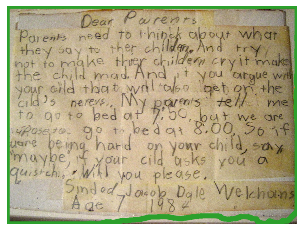

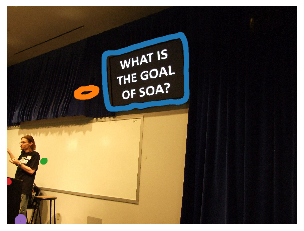

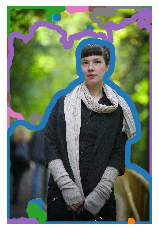

KeyboardInterrupt: 

In [37]:
# Apply the rules.
rules_func = dataFrameRulesToMapping(d, dictionary_of_datasets["semantic_scene_GT"]["not_in_consequents"])
# Type of data used for rules.
data_names = "semantic_scene"
list_poly_to_obfuscate = rules_func(eval_dictionary_of_datasets[data_names]["data"], 0.0)

# Save the outputs.
# Save the polygons
image_folder = "../dataset_images"

file_path_saving = "mined_" + data_names + "_200"
if not os.path.exists(file_path_saving):
    os.makedirs(file_path_saving)
with open("list_eval_images.json") as json_file:
    list_images = json.load(json_file)


for image_name, polys in zip(list_images, list_poly_to_obfuscate):
    polys = list(filter(lambda a: a != None, polys))
    polys_clean = [] 
    for poly in polys:
        if poly.type == "Polygon":
            polys_clean.append(poly)
    polys = polys_clean  #points[points.geometry.type == 'Point']

    # Post-process the final polygons
    if len(polys) > 1:
        polys_to_obfuscate_final = image_u.post_process_polygons(polys)
    else:
        polys_to_obfuscate_final = polys
    image_u.save_polygons(file_path_saving + ".json", polys_to_obfuscate_final, Path(image_name).stem )
    # Save the images
    # Prediction polygons
    
    save_file = Path(file_path_saving + "/") / (Path(image_name).stem + ".png")
    input_image_file = Path(image_folder + "/" + image_name)
    #printPolygons(input_image_file, polys_to_obfuscate, save_file)
    image_u.printPolygons(input_image_file, polys_to_obfuscate_final, save_file)
    

In [2]:
# Evaluate the outputs.
data_names = "semantic_scene"
file_path_saving = "mined_" + data_names + "_200"

# Read the ground truth file.
with open(Path('../val2017.json'), 'r') as f:
    ground_truth = json.load(f)
ground_truth = ground_truth['annotations']
# Read the prediction file.
with open(Path(file_path_saving + ".json"), 'r') as f:
    list_predictions = json.load(f)
list_predictions = list_predictions["list_image_poly"]


prediction_list = list_predictions
ground_truth_list = ground_truth

In [3]:
rate_obuscation_per_privacy_element = eval_u.evaluationPerPrivacyElement(prediction_list, ground_truth_list)

In [4]:
print(eval_u.aggregateResultsPrivacyElement(rate_obuscation_per_privacy_element))

{'a111_name_all': [0.3398499336583678, 0.4677650490014338], 'a82_date_time': [0.37232377364870795, 0.4711997061036191], 'a35_mail': [0.1713201211446289, 0.3867454473898328], 'a26_handwriting': [0.45702449115441485, 0.5043070791248596], 'a109_person_body': [0.4256145044657184, 0.43924679216535495], 'a105_face_all': [0.46201148973746076, 0.47446665633259394], 'a85_username': [0.09150984298114458, 0.30131386878446415], 'a18_ethnic_clothing': [0.29132760801556395, 0.4363185319512837], 'a39_disability_physical': [0.4209557300368296, 0.3903719361402036], 'a106_address_current_all': [0.3464880547463419, 0.46308500866731594], 'a31_passport': [0.5592901508667472, 0.49875328190340484], 'a8_signature': [0.48204640187884185, 0.5062779137970681], 'a107_address_home_all': [0.6334130223116924, 0.4800213920470128], 'a30_credit_card': [0.20579760611478035, 0.39350575523124687], 'a24_birth_date': [0.3660620748790811, 0.4660921303745965], 'a73_landmark': [0.23606686788529607, 0.41089302199052186], 'a29_a

In [5]:
#eval_dictionary_of_datasets[data_names]["data"]

In [6]:

prediction_list = list_predictions
ground_truth_list = ground_truth

segment_list= [2, 4, 8, 12, 16, 20]

dict_results = eval_u.evaluationPerPixel(prediction_list, ground_truth_list, segment_list)

# Aggregate the results
dict_results_agg = eval_u.aggregateResultsPrivacyElement(dict_results)
dict_results_agg_no_nan = eval_u.aggregateResultsPrivacyElement(dict_results, "nonan")

In [7]:
print(dict_results_agg)
print(dict_results_agg_no_nan)

{'pixel_accuracy': [0.34779422849020325, 0.43764830430846613], 'pixel_precision': [nan, nan], 'pixel_recall': [0.34779422849020325, 0.43764830430846613], '2_accuracy': [0.6153846153846154, 0.41189826917934214], '2_precision': [nan, nan], '2_recall': [nan, nan], '4_accuracy': [0.6211271367521367, 0.37458330923033645], '4_precision': [nan, nan], '4_recall': [nan, nan], '8_accuracy': [0.6612246260683761, 0.2913362967185668], '8_precision': [nan, nan], '8_recall': [nan, nan], '12_accuracy': [0.6420272435897436, 0.2989992200782387], '12_precision': [nan, nan], '12_recall': [nan, nan], '16_accuracy': [0.6106850961538461, 0.3172908312771598], '16_precision': [nan, nan], '16_recall': [nan, nan], '20_accuracy': [0.6317708333333333, 0.2928437070553901], '20_precision': [nan, nan], '20_recall': [nan, nan]}
{'pixel_accuracy': [0.34779422849020325, 0.4365949975964769], 'pixel_precision': [0.44818909548624725, 0.39050512564931783], 'pixel_recall': [0.34779422849020325, 0.4365949975964769], '2_accura

In [15]:
# Evaluation of the different configurations of rules.


In [14]:
## Training data.
list_semantic_file = "200_training_semantic_seg_info.json"
list_GT_infos_file = "GT_200_training_images.json"
list_scene_file = "200_training_scene_info.json"
list_OCR_file = "200_training_OCR_info.json"

list_semantic = openJsonInputs(list_semantic_file)
list_scene = openJsonInputs(list_scene_file)
list_GT_infos = openJsonInputs(list_GT_infos_file)
list_OCR = openJsonInputs(list_OCR_file)

# Read the ground truth file.
with open(Path('../val2017.json'), 'r') as f:
    ground_truth = json.load(f)
ground_truth = ground_truth['annotations']
segment_list= [2, 4, 8, 12, 16, 20]


### Test data.
# Get the evaluation data with their encoding for rules.
list_semantic_file_eval = "eval_semantic_seg_info.json"
list_scene_file_eval = "eval_scene_info.json"
list_OCR_file_eval = "eval_OCR_info.json"
list_semantic_eval = openJsonInputs(list_semantic_file_eval)
list_scene_eval = openJsonInputs(list_scene_file_eval)
list_OCR_eval = openJsonInputs(list_OCR_file_eval)

all_element_semantic, all_element_scene, all_element_OCR, \
        dataset_semantic, dataset_scene, dataset_OCR = \
        createListsForDatasetsEvaluation(list_semantic_eval, list_scene_eval, list_OCR_eval)
eval_dictionary_of_datasets = createDatasetAssociationsForEvaluation(all_element_semantic, all_element_scene, all_element_OCR, \
        dataset_semantic, dataset_scene, dataset_OCR) # dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique, \

with open("list_eval_images.json") as json_file:
    list_images = json.load(json_file)



def getTrainingDataSegment(nb_data, list_semantic, list_scene, list_GT_infos, list_OCR):
    # Get random indices.
    sampled_indices = random.sample(range(len(list_scene)), nb_data)
    # Get the new lists.
    new_list_semantic = [list_semantic[i] for i in sampled_indices] 
    new_list_scene = [list_scene[i] for i in sampled_indices] 
    new_list_OCR = [list_OCR[i] for i in sampled_indices] 
    new_list_GT_infos = [list_GT_infos[i] for i in sampled_indices] 
    
    return new_list_semantic, new_list_scene, new_list_GT_infos, new_list_OCR

def preProcessTrainingData(list_semantic, list_scene, list_GT_infos, list_OCR):
    all_element_GT, all_element_semantic, all_element_scene, all_element_OCR, \
            dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique, dataset_GT_unique, \
            dataset_semantic, dataset_scene, dataset_OCR, dataset_GT = \
            createListsForDatasets(list_semantic, list_scene, list_OCR, list_GT_infos)

    dictionary_of_datasets = createDatasetAssociations(all_element_GT, all_element_semantic, all_element_scene, all_element_OCR, \
            dataset_semantic_unique, dataset_scene_unique, dataset_OCR_unique, dataset_GT_unique, \
            dataset_semantic, dataset_scene, dataset_OCR, dataset_GT)
    
    return dictionary_of_datasets

### Parameters for evaluation.
nb_training_data = [50, 100, 150, 200]
rule_data_type = ["semantic_scene_GT_unique", "semantic_scene_OCR_GT_unique", "semantic_GT_unique"]
rules_support = [0.1, 0.4] # done for 0.7 nothing works, 0.7]
rules_lift = [0.0, 0.3, 0.6, 0.9, 1.1]
rules_confidence = [0.3, 0.6, 0.9]#[0.0, 0.3, 0.6, 0.9]
threshold_rules_to_keep = [0.0, 0.3, 0.6]



In [15]:
nb_training_data = [50] #, 100, 150, 200]
rule_data_type = ["semantic_GT_unique"]

rules_support = [0.1, 0.4, 0.7]
rules_lift = [0.9, 1.1]
rules_confidence = [0.3, 0.6, 0.9]#[0.3, 0.6, 0.9]
threshold_rules_to_keep = [0.0, 0.3, 0.6]
# AFTER WE RUN except lift 0.3 for confidence 0.3 and 0.6

# We will need to run the support thres 0.4 with the remaining conditions:
#rules lift = [0.0, 0.3, 0.6]
#rules_confidence = [0.6, 0.9]
#threshold_rules_to_keep = [0.0, 0.3, 0.6]



In [16]:
folder_saving = "./results/"
if not os.path.exists(folder_saving):
    os.makedirs(folder_saving)
    
# Result file.
json_file_results = Path(folder_saving+ "results_exp_automatic.json")

TODO: we only handle entries with a single elements of each class.
Start dealing with  {'nb_training_data': 50, 'type_data': 'semantic_GT_unique', 'support_thresh': 0.1, 'lift_thresh': 0.9, 'confidence_thresh': 0.3, 'rule_thresh': 0.0}
True
C:\Users\Agathe Balayn\Documents\phd\projects\privacy_crowdsourcing\dev\man_machine_privatisation\results\mined_50_semantic_GT_unique_0.1_0.9_0.3_0.0


MemoryError: 

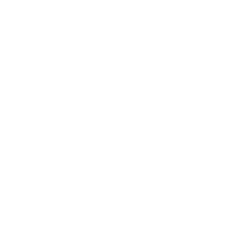

In [17]:
### Evaluation loop.
folder_saving = "./results/"
if not os.path.exists(folder_saving):
    os.makedirs(folder_saving)
    
# Result file.
json_file_results = Path(folder_saving+ "results_exp_automatic.json")

for data_segment_nb in nb_training_data:
    # Get training data.
    new_list_semantic, new_list_scene, new_list_GT_infos, new_list_OCR = getTrainingDataSegment(data_segment_nb, list_semantic, list_scene, list_GT_infos, list_OCR)
    dictionary_of_datasets = preProcessTrainingData(new_list_semantic, new_list_scene, new_list_GT_infos, new_list_OCR)
    # Get rules.
    for data_names in rule_data_type:
        for param_rules_support in rules_support:
            for param_rules_lift in rules_lift:
                for param_rules_confidence in rules_confidence:
                    rules, frequent_itemsets = getRules(dictionary_of_datasets[data_names]["data"], param_rules_support, param_rules_lift, param_rules_confidence)
                    filtered_rules = getPredictionRules(rules, dictionary_of_datasets[data_names]["not_in_consequents"], dictionary_of_datasets[data_names]["not_in_antecedents"])
                    d = postProcessRules(filtered_rules.copy())
                    if len(d) > 1:
                        rules_func = dataFrameRulesToMapping(d, dictionary_of_datasets[data_names]["not_in_consequents"])
                        # Apply the rules to the test data.
                        data_names_test = data_names
                        data_names_test = data_names_test.replace('_GT_unique','')
                        for rule_threshold in threshold_rules_to_keep:
                            method_type = "mined_rules"
                            method_param = {"nb_training_data": data_segment_nb, "type_data": data_names,\
                                           "support_thresh":param_rules_support,\
                                           "lift_thresh":param_rules_lift,\
                                           "confidence_thresh":param_rules_confidence,\
                                           "rule_thresh":rule_threshold} 
                            print("Start dealing with ", method_param)
                            list_poly_to_obfuscate = rules_func(eval_dictionary_of_datasets[data_names_test]["data"], rule_threshold)
                            # Save the polygons.                
                            image_folder = "../dataset_images"
                            file_path_saving = "mined_" + str(data_segment_nb) + "_" +\
                            data_names + "_" + str(param_rules_support) + "_" + str(param_rules_lift) +\
                            "_" + str(param_rules_confidence) + "_" + str(rule_threshold)
                            if not os.path.exists(Path(folder_saving + file_path_saving)):
                                os.makedirs(Path(folder_saving+file_path_saving))
                            print(os.path.isdir(Path(folder_saving+file_path_saving)))
                            print(os.path.abspath(Path(folder_saving+file_path_saving)))
                            
                            for image_name, polys in zip(list_images, list_poly_to_obfuscate):
                                #print(image_name)
                                polys = list(filter(lambda a: a != None, polys))
                                polys_clean = [] 
                                for poly in polys:
                                    if poly.type == "Polygon":
                                        polys_clean.append(poly)
                                polys = polys_clean 
                                if len(polys) > 1:
                                    polys_to_obfuscate_final = image_u.post_process_polygons(polys)
                                else:
                                    polys_to_obfuscate_final = polys
                                # Remove empty polygons.
                                polys_clean = [] 
                                for poly in polys_to_obfuscate_final:
                                    if not poly.is_empty:
                                        polys_clean.append(poly)
                                polys_to_obfuscate_final = polys_clean
                                while True:
                                    n = 0
                                    break_ = False
                                    while True:
                                        n = n+1
                                        try:  
                                            image_u.save_polygons(Path(folder_saving+file_path_saving + ".json"), polys_to_obfuscate_final, Path(image_name).stem )
                                            
                                        except:
                                            print("looping ", n)
                                            if (n>50):
                                                break_ = True
                                                break
                                            pass
                                        else:
                                            break_ = True
                                            break
                                        
                                    if (n>50) or break_:
                                        break                                # Save the images.
                                save_file = Path(folder_saving + file_path_saving + "/") / (Path(image_name).stem + ".png")
                                input_image_file = Path(image_folder + "/" + image_name)
                                #printPolygons(input_image_file, polys_to_obfuscate, save_file)
                                image_u.printPolygons(input_image_file, polys_to_obfuscate_final, save_file)
                            del list_poly_to_obfuscate, polys_to_obfuscate_final, input_image_file
                            del poly, polys, polys_clean
                            # Compute evaluation measures.
                            with open(Path(folder_saving + file_path_saving + ".json"), 'r') as f:
                                list_predictions = json.load(f)
                            list_predictions = list_predictions["list_image_poly"]
                            prediction_list = list_predictions
                            ground_truth_list = ground_truth
                            print("Computing the results.")
                            rate_obuscation_per_privacy_element = eval_u.evaluationPerPrivacyElement(prediction_list, ground_truth_list)
                            dict_results = eval_u.evaluationPerPixel(prediction_list, ground_truth_list, segment_list)
                            dict_results_agg = eval_u.aggregateResultsPrivacyElement(dict_results)
                            dict_results_agg_no_nan = eval_u.aggregateResultsPrivacyElement(dict_results, "nonan")
                            # Save evaluation measures.   
                            
                            
                            per_privacy_element_result = [dict_results_agg, dict_results_agg_no_nan]
                            per_pixel_result = dict_results
                            writeResultsToJson(json_file_results, method_type, method_param, per_privacy_element_result,\
                                                   per_pixel_result)
                            print("Finished dealing with ", method_param)
                    else:
                        method_type = "mined_rules"
                        method_param = {"nb_training_data": data_segment_nb, "type_data": data_names,\
                                           "support_thresh":param_rules_support,\
                                           "lift_thresh":param_rules_lift,\
                                           "confidence_thresh":param_rules_confidence,\
                                           "rule_thresh":"NA"} 
                        print(method_param)
                        per_privacy_element_result = ["NA", "NA"]
                        per_pixel_result = "NA"
                        writeResultsToJson(json_file_results, method_type, method_param, per_privacy_element_result,\
                                                   per_pixel_result)

In [30]:
writeResultsToJson(json_file_results, method_type, method_param, per_privacy_element_result,\
                                                   per_pixel_result)

In [17]:
data_segment_nb = 50
data_names = 'semantic_scene_OCR_GT_unique'
param_rules_support = 0.1
param_rules_lift = 0.6
param_rules_confidence = 0.9
rule_threshold = 0.3
file_path_saving = "mined_" + str(data_segment_nb) + "_" +\
                            data_names + "_" + str(param_rules_support) + "_" + str(param_rules_lift) +\
                            "_" + str(param_rules_confidence) + "_" + str(rule_threshold)
with open(Path(folder_saving + file_path_saving + ".json"), 'r') as f:
                            list_predictions = json.load(f)
                            list_predictions = list_predictions["list_image_poly"]
                            prediction_list = list_predictions
                            ground_truth_list = ground_truth
                            rate_obuscation_per_privacy_element = eval_u.evaluationPerPrivacyElement(prediction_list, ground_truth_list)
                            dict_results = eval_u.evaluationPerPixel(prediction_list, ground_truth_list, segment_list)
                            dict_results_agg = eval_u.aggregateResultsPrivacyElement(dict_results)
                            dict_results_agg_no_nan = eval_u.aggregateResultsPrivacyElement(dict_results, "nonan")
                            # Save evaluation measures.   
                            method_type = "mined_rules"
                            method_param = {"nb_training_data": data_segment_nb, "type_data": data_names,\
                                           "support_thresh":param_rules_support,\
                                           "lift_thresh":param_rules_lift,\
                                           "confidence_thresh":param_rules_confidence,\
                                           "rule_thresh":rule_threshold} 
                            print(method_param)
                            per_privacy_element_result = [dict_results_agg, dict_results_agg_no_nan]
                            per_pixel_result = dict_results
                            writeResultsToJson(json_file_results, method_type, method_param, per_privacy_element_result,\
                                                   per_pixel_result)

{'nb_training_data': 50, 'type_data': 'semantic_scene_OCR_GT_unique', 'support_thresh': 0.1, 'lift_thresh': 0.3, 'confidence_thresh': 0.6, 'rule_thresh': 0.6}


In [ ]:
# Do missed round.
file_path_saving = "mined_" + str(data_segment_nb) + "_" +\
                            data_names + "_" + str(param_rules_support) + "_" + str(param_rules_lift) +\
                            "_" + str(param_rules_confidence) + "_" + str(rule_threshold)
#file_path_saving = file_path_saving.replace(".", "")                            
folder_saving = "./results/"
if not os.path.exists(Path(folder_saving + file_path_saving)):
                                os.makedirs(Path(folder_saving+file_path_saving))
for image_name, polys in zip(list_images, list_poly_to_obfuscate):
                                print(image_name)
                                polys = list(filter(lambda a: a != None, polys))
                                polys_clean = [] 
                                for poly in polys:
                                    if poly.type == "Polygon":
                                        polys_clean.append(poly)
                                polys = polys_clean 
                                if len(polys) > 1:
                                    polys_to_obfuscate_final = image_u.post_process_polygons(polys)
                                else:
                                    polys_to_obfuscate_final = polys
                                # Remove empty polygons.
                                polys_clean = [] 
                                for poly in polys_to_obfuscate_final:
                                    if not poly.is_empty:
                                        polys_clean.append(poly)
                                polys_to_obfuscate_final = polys_clean
                                
                                print(os.path.abspath(Path(folder_saving+file_path_saving + ".json")))
                                while True:
                                    n = 0
                                    break_ = False
                                    while True:
                                        n = n+1
                                        try:
                                            
                                            image_u.save_polygons(Path(folder_saving+file_path_saving + ".json"), polys_to_obfuscate_final, Path(image_name).stem )
                                        except:
                                            print("looping ", n)
                                            pass
                                        else:
                                            break_ = True
                                            break
                                    if (n>50) or break_:
                                        break
                                 # Save the images.
                                save_file = Path(folder_saving + file_path_saving + "/") / (Path(image_name).stem + ".png")
                                input_image_file = Path(image_folder + "/" + image_name)
                                #printPolygons(input_image_file, polys_to_obfuscate, save_file)
                                image_u.printPolygons(input_image_file, polys_to_obfuscate_final, save_file)
# Compute evaluation measures.
with open(Path(folder_saving + file_path_saving + ".json"), 'r') as f:
    list_predictions = json.load(f)
list_predictions = list_predictions["list_image_poly"]
prediction_list = list_predictions
ground_truth_list = ground_truth
rate_obuscation_per_privacy_element = eval_u.evaluationPerPrivacyElement(prediction_list, ground_truth_list)
dict_results = eval_u.evaluationPerPixel(prediction_list, ground_truth_list, segment_list)
dict_results_agg = eval_u.aggregateResultsPrivacyElement(dict_results)
dict_results_agg_no_nan = eval_u.aggregateResultsPrivacyElement(dict_results, "nonan")
# Save evaluation measures.   
method_type = "mined_rules"
method_param = {"nb_training_data": data_segment_nb, "type_data": data_names,\
                                           "support_thresh":param_rules_support,\
                                           "lift_thresh":param_rules_lift,\
                                           "confidence_thresh":param_rules_confidence,\
                                           "rule_thresh":rule_threshold} 
print(method_param)
per_privacy_element_result = [dict_results_agg, dict_results_agg_no_nan]
per_pixel_result = dict_results
writeResultsToJson(json_file_results, method_type, method_param, per_privacy_element_result,\
                                                   per_pixel_result)